<a href="https://colab.research.google.com/github/garciakjp/Movie_Recommendation_System/blob/main/BAM_3034_Assignment_10_(TMDB_Movie_Recommendation_System).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
# Importing related libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json

## Data Loading
Importing the two datasets and merging them.

In [2]:
#### Data cards

#The Movie Database provides two datasets:
#**tmdb_5000_movies.csv (Movie credits data):**
#- budget - genres - homepage - id - keywords - original_language - original_title - overview - popularity - production_companies - production_countries - release_date - revenue - runtime - spoken_languages - status - tagline - title - vote_average - vote_count

#**tmdb_5000_credits.csv:**
#- movie_id
#- title
#- cast
#- crew

#We will merge the two datasets in order to get all the information about the actors and the directors of their relative movie.

In [4]:
# Importing the datasets
credits_df=pd.read_csv('tmdb_5000_credits.csv')
movies_df=pd.read_csv('tmdb_5000_movies.csv')

In [5]:
# Merging
credits_df.columns = ['id','tittle','cast','crew']
df= credits_df.merge(movies_df,on='id')

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1154 non-null   int64  
 1   tittle                1154 non-null   object 
 2   cast                  1154 non-null   object 
 3   crew                  1154 non-null   object 
 4   budget                1154 non-null   int64  
 5   genres                1154 non-null   object 
 6   homepage              577 non-null    object 
 7   keywords              1154 non-null   object 
 8   original_language     1154 non-null   object 
 9   original_title        1154 non-null   object 
 10  overview              1154 non-null   object 
 11  popularity            1154 non-null   float64
 12  production_companies  1154 non-null   object 
 13  production_countries  1154 non-null   object 
 14  release_date          1154 non-null   object 
 15  revenue              

## Data Cleaning and Preprocessing
There are some NaNs and unavailable data in the database. \
It's required to clean these datas and prepare it for the next section (EDA - Exploratory Data Analysis).

In [7]:
# Making a Copy to don't mess the data for the Modeling section.
df_EDA = df.copy(deep=True)
# Finding howmany Nulls are there.
df_EDA.isnull().sum()

,0
id,0
tittle,0
cast,0
crew,0
budget,0
genres,0
homepage,577
keywords,0
original_language,0
original_title,0


In [8]:
# Dropping the unrelated info for the EDA
df_EDA.drop(['homepage', 'tagline', 'id', 'overview', 'original_title', 'tittle'] ,axis = 1,inplace = True)

In [9]:
# Replacing the 2 null runtimes with the mean of all movies
df_EDA['runtime'] = df_EDA['runtime'].fillna(df_EDA['runtime'].mean())

In [10]:
# Removing any NaN
df_EDA = df_EDA.dropna()
# Removing any Duplicates
df_EDA = df_EDA.drop_duplicates()
# Counting the null values in each attribute
df_EDA.isnull().sum()

,0
cast,0
crew,0
budget,0
genres,0
keywords,0
original_language,0
popularity,0
production_companies,0
production_countries,0
release_date,0


In [11]:
# Creating a Year feature for easier analysis
df_EDA['release_date'] = pd.to_datetime(df_EDA['release_date'])
df_EDA['year'] = df_EDA['release_date'].dt.year
df_EDA['year']

,year
0,2009
1,2007
2,2015
3,2012
4,2012
...,...
1149,2013
1150,2009
1151,1999
1152,1989


In [12]:
# Creating a profit and is_profitable feature for easier analysis
df_EDA['profit'] = df_EDA['revenue'] - df_EDA['budget']
df_EDA['is_profitable'] = df_EDA['profit'] > 0

In [13]:
# A simple Overview
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cast                  1154 non-null   object        
 1   crew                  1154 non-null   object        
 2   budget                1154 non-null   int64         
 3   genres                1154 non-null   object        
 4   keywords              1154 non-null   object        
 5   original_language     1154 non-null   object        
 6   popularity            1154 non-null   float64       
 7   production_companies  1154 non-null   object        
 8   production_countries  1154 non-null   object        
 9   release_date          1154 non-null   datetime64[ns]
 10  revenue               1154 non-null   int64         
 11  runtime               1154 non-null   float64       
 12  spoken_languages      1154 non-null   object        
 13  status            

In [14]:
# Head of the DF
df_EDA.head(5)

,cast,crew,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,year,profit,is_profitable
0,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,2009,2550965087,True
1,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,2007,661000000,True
2,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466,2015,635674609,True
3,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106,2012,834939099,True
4,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124,2012,24139100,True


## EDA (Exploratory Data Analysis)

In [15]:
df_EDA.describe()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,year,profit
count,1.154000e+03,1154.000000,1154,1.154000e+03,1154.000000,1154.000000,1154.000000,1154.000000,1.154000e+03
mean,8.379576e+07,42.725577,2005-08-23 11:12:34.939341312,2.331120e+08,115.604853,6.210919,1611.538995,2005.092721,1.493162e+08
min,0.000000e+00,0.146783,1940-02-23 00:00:00,0.000000e+00,0.000000,2.300000,1.000000,1940.000000,-1.657101e+08
25%,5.000000e+07,18.098306,2000-12-09 12:00:00,6.624558e+07,100.000000,5.700000,388.000000,2000.000000,2.775517e+06
50%,7.000000e+07,31.459205,2006-03-05 00:00:00,1.552282e+08,114.000000,6.200000,914.500000,2006.000000,8.105499e+07
75%,1.000000e+08,51.307939,2011-05-25 00:00:00,3.028864e+08,127.000000,6.700000,2058.500000,2011.000000,2.055504e+08
max,3.800000e+08,875.581305,2016-08-17 00:00:00,2.787965e+09,248.000000,8.300000,13752.000000,2016.000000,2.550965e+09
std,4.898691e+07,51.882317,NaN,2.580752e+08,21.966935,0.806480,1898.488374,7.463765,2.293861e+08


In [16]:
def find_popularity(year_1 = 0 , year_2 = 0) :
    sorted_popularity = df_EDA.sort_values(by = 'popularity',ascending= False)
    if year_2 == 0 :
        year_2 = year_1
    if year_1 != 0 :
        sorted_popularity.query('year >= @year_1 and year <= @year_2',inplace = True)
    plt.subplots(figsize=(10,8))
    plt.gca().invert_yaxis()
    plt.barh(sorted_popularity['title'].head(10),sorted_popularity['popularity'].head(10))

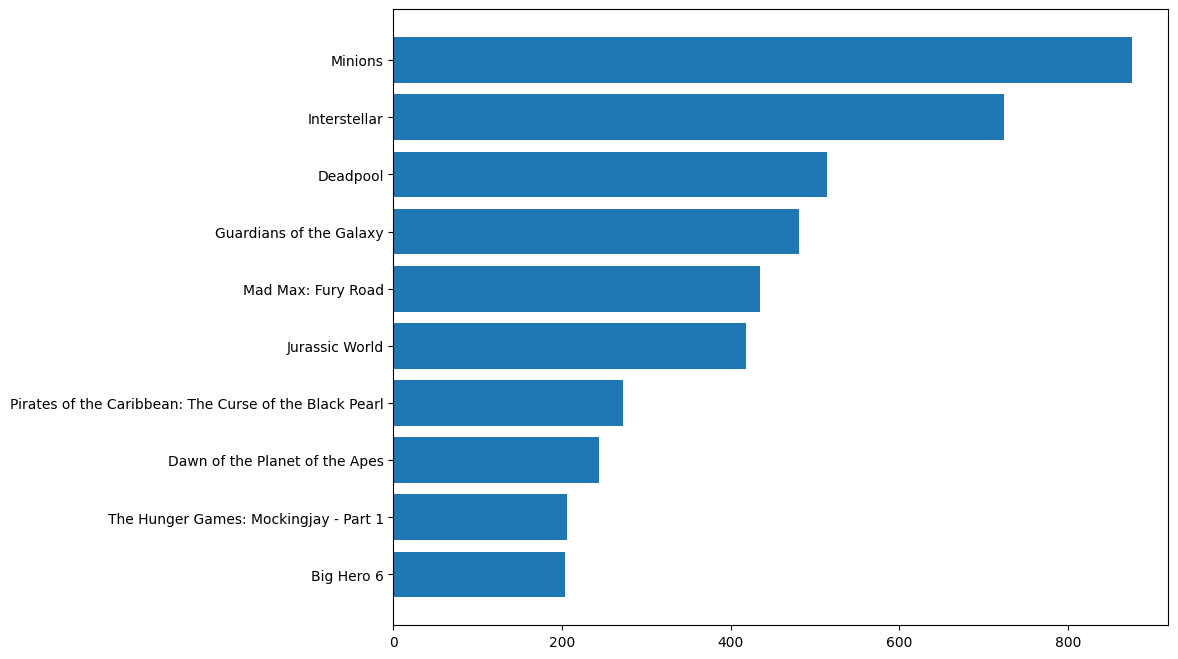

In [17]:
find_popularity()

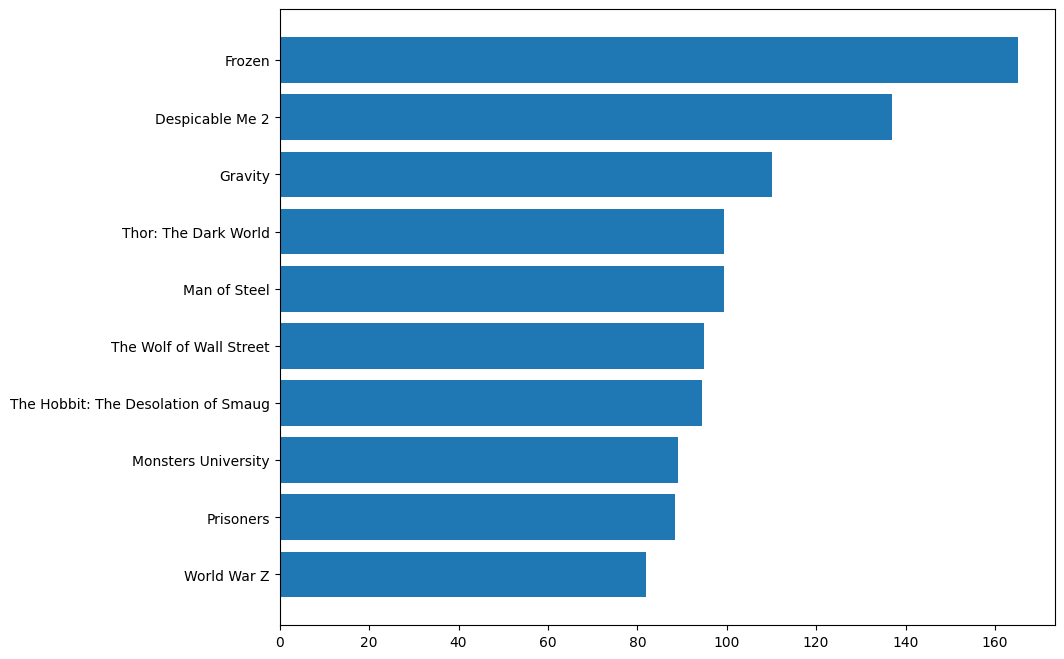

In [18]:
find_popularity(2013) # For the year == 2013

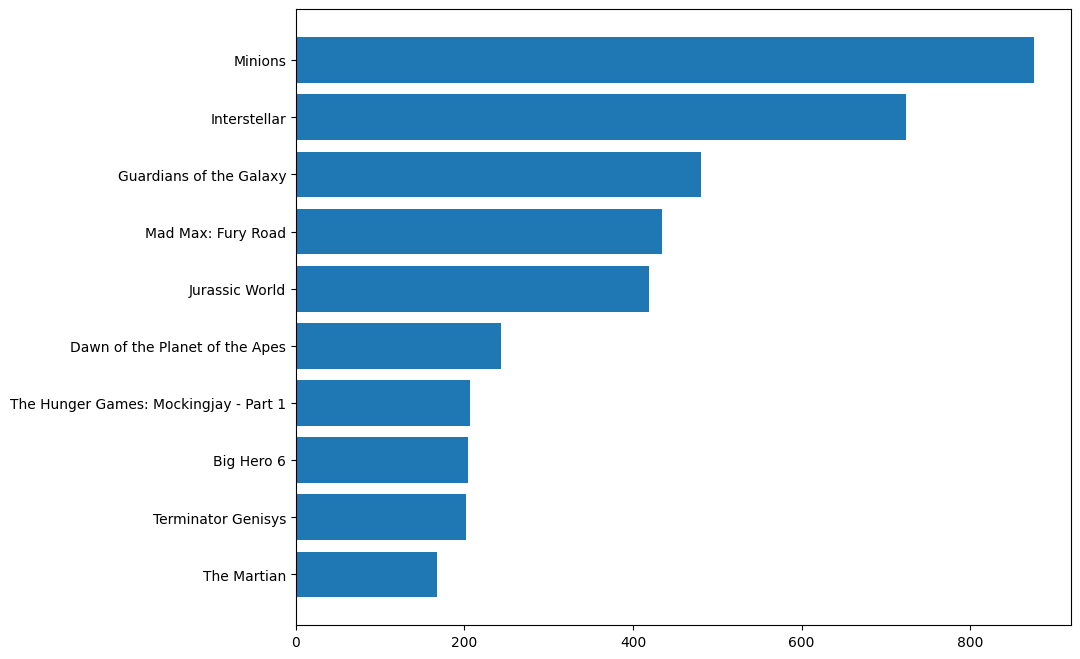

In [19]:
find_popularity(2013,2015) # For the 2013 <= year <= 2015

In [20]:
def find_genres(year_1 = 0 , year_2 = 0) :
    sorted_popularity = df_EDA.sort_values(by = 'popularity',ascending= False)
    if year_2 == 0 :
        year_2 = year_1
    if year_1 != 0 :
        sorted_popularity.query('year >= @year_1 and year <= @year_2',inplace = True)
    z = list()
    print(sorted_popularity.shape)
    counter = 0
    for i in sorted_popularity['genres'] :
        i = json.loads(i)
        for dic in i :
            dict(dic)
        z.append(dic.get('name'))
        counter +=1
        if counter >=sorted_popularity['genres'].shape[0]/2 :
            break
    unique_genres = set(z)
    counts = dict()
    for i in z:
      counts[i] = counts.get(i, 0) + 1
    plt.subplots(figsize=(10,8))
    plt.gca().invert_yaxis()
    plt.barh(list(counts.keys()),list(counts.values()))

(1154, 20)


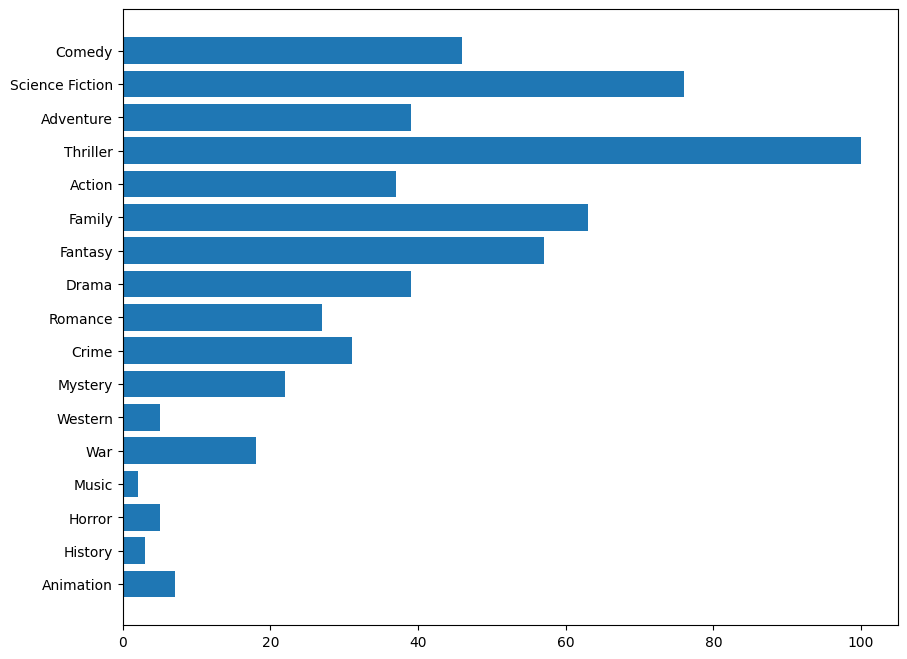

In [21]:
find_genres()

(52, 20)


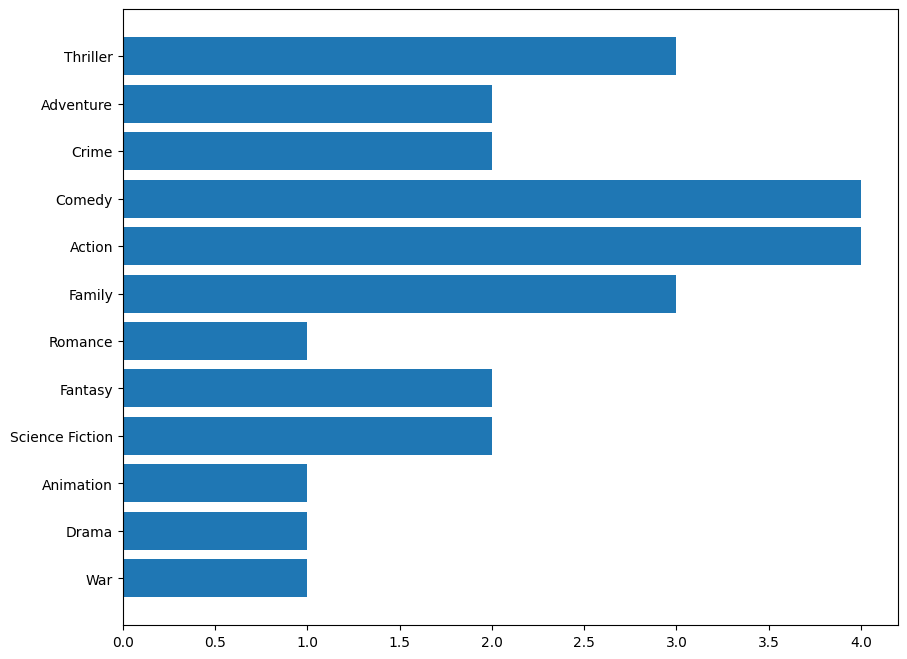

In [22]:
find_genres(2008) # For the year == 2008

(612, 20)


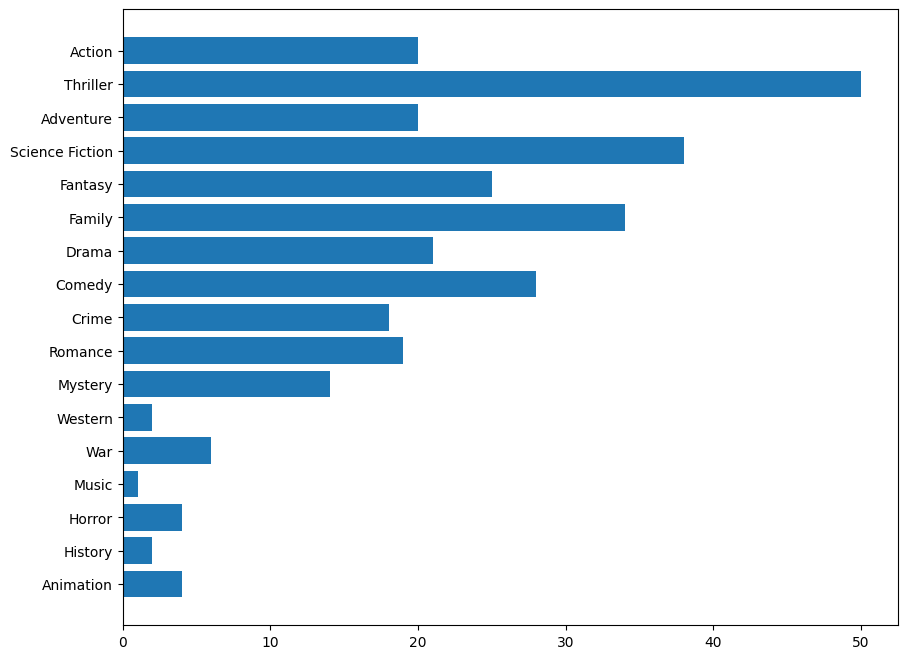

In [23]:
find_genres(2002,2012) # For the 2010 <= year <= 2012

In [24]:
sorted_revenues = df_EDA.sort_values(by = 'revenue',ascending= False)
low_revenues = df_EDA[df_EDA['revenue'] < df_EDA['revenue'].median()]
high_revenues = df_EDA[df_EDA['revenue'] >= df_EDA['revenue'].median()]
z = list()
counter = 0
for i in high_revenues['production_companies'] :
    i = json.loads(i)
    for dic in i :
        dict(dic)
    z.append(dic.get('name'))
unique_genres = set(z)
counts = dict()
for i in z:
    counts[i] = counts.get(i, 0) + 1
s = pd.DataFrame(list(counts.values()),list(counts.keys()),columns=['counts'])
s= s.sort_values(by='counts',ascending= False)
print(s)

                                 counts
Warner Bros.                         24
DreamWorks Animation                 20
Pixar Animation Studios              14
Twentieth Century Fox Animation      10
Revolution Sun Studios               10
...                                 ...
Calle Cruzada                         1
Franklin/Waterman Productions         1
Dawliz                                1
Digital Image Associates              1
U-Drive Productions                   1

[312 rows x 1 columns]


In [25]:
# Extract Companies from JSON objects
companies_list = []
for companies_str in df_EDA['production_companies']:
    data = json.loads(companies_str)
    names = [item['name'] for item in data]
    companies_list.extend(names)
companies_count = {i:companies_list.count(i) for i in companies_list}
# Sort the dictionary by company count
sorted_companies_count = dict(sorted(companies_count.items(), key=lambda item: item[1], reverse=True))

# Display sorted companies and their counts
for i, (company, count) in enumerate(sorted_companies_count.items()):
    if i < 5:
        print(f"{company}: {count}")
    else:
        break

Warner Bros.: 163
Universal Pictures: 138
Paramount Pictures: 115
Columbia Pictures: 102
Twentieth Century Fox Film Corporation: 101


### Correlation

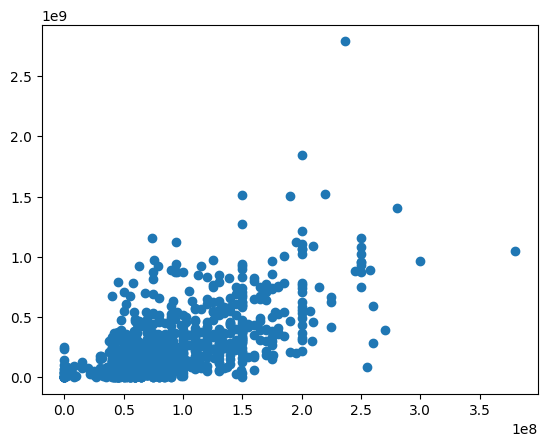

In [26]:
plt.scatter(df_EDA['budget'],df_EDA['revenue'])

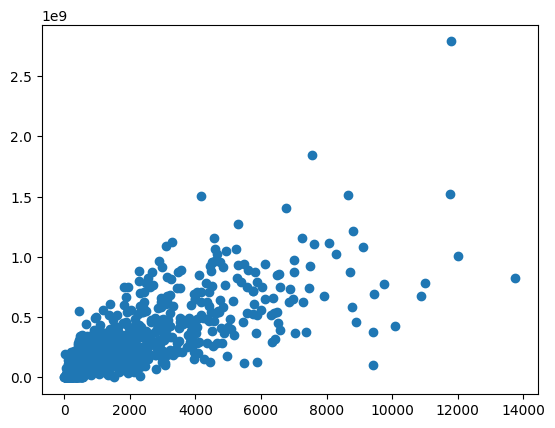

In [27]:
plt.scatter(df_EDA['vote_count'],df_EDA['revenue'])

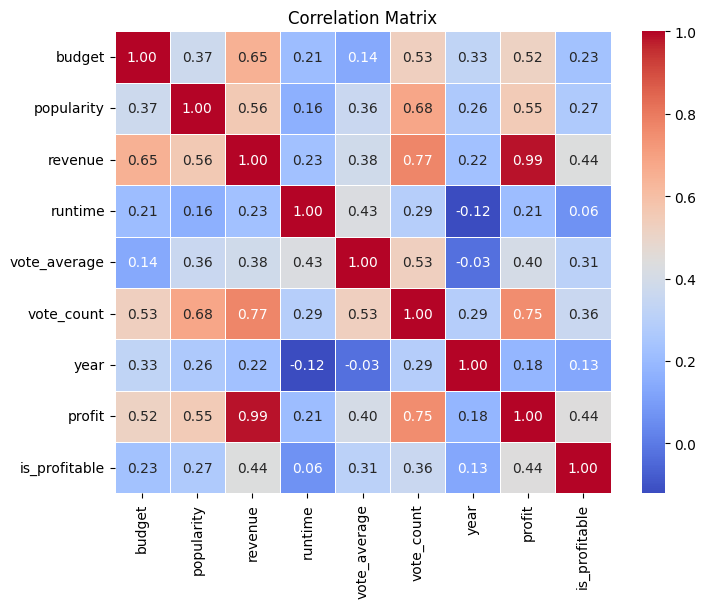

In [28]:
columns_for_corr = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'profit', 'is_profitable']
df_EDA_corr = df_EDA[columns_for_corr]
correlation_matrix = df_EDA_corr.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Changes over years

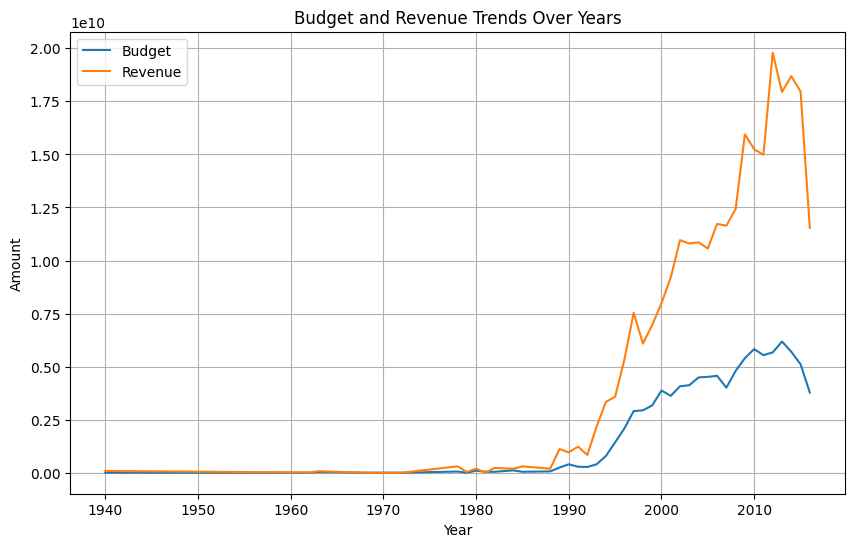

In [29]:
data_release_date = df_EDA.sort_values('year')
budget1 = data_release_date.groupby('year')['budget'].sum()
revenue1 = data_release_date.groupby('year')['revenue'].sum()
# Plotting
plt.figure(figsize=(10, 6))

# Plot budget trend
plt.plot(budget1.index, budget1.values, label='Budget')

# Plot revenue trend
plt.plot(revenue1.index, revenue1.values, label='Revenue')

# Customize the plot
plt.title('Budget and Revenue Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

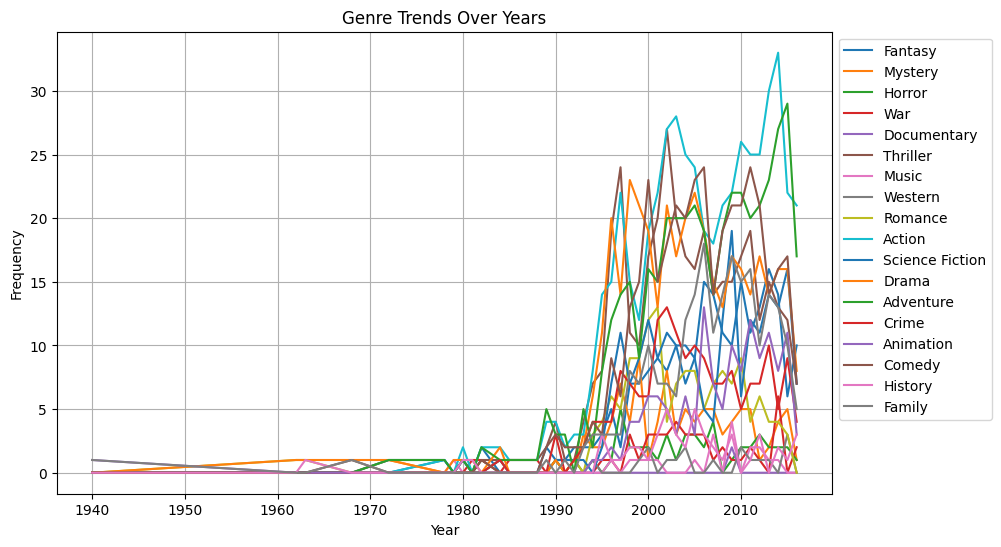

In [30]:
# Extract genres from JSON objects
genres_list = []
for genre_str in data_release_date['genres']:
    data = json.loads(genre_str)
    names = [item['name'] for item in data]
    genres_list.extend(names)

# Create a set of unique genres
unique_genres = set(genres_list)

# Initialize a dictionary to store genre counts for each year
genre_counts = {genre: [] for genre in unique_genres}

# Calculating the count of each genre in each year
for year in sorted(data_release_date['year'].unique()):
    year_data = data_release_date[data_release_date['year'] == year]
    genres_list = []
    for genre_str in year_data['genres']:
        data = json.loads(genre_str)
        names = [item['name'] for item in data]
        genres_list.extend(names)
    genres_list = {i : genres_list.count(i) for i in genres_list}
    for genre in unique_genres:
        try:
            genre_counts[genre].append(genres_list[genre])
        except KeyError:
            genre_counts[genre].append(0)

# Plot trend lines for each genre
plt.figure(figsize=(10, 6))
for genre in unique_genres:
    plt.plot(data_release_date['year'].unique(), genre_counts[genre], label=genre)

plt.title('Genre Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


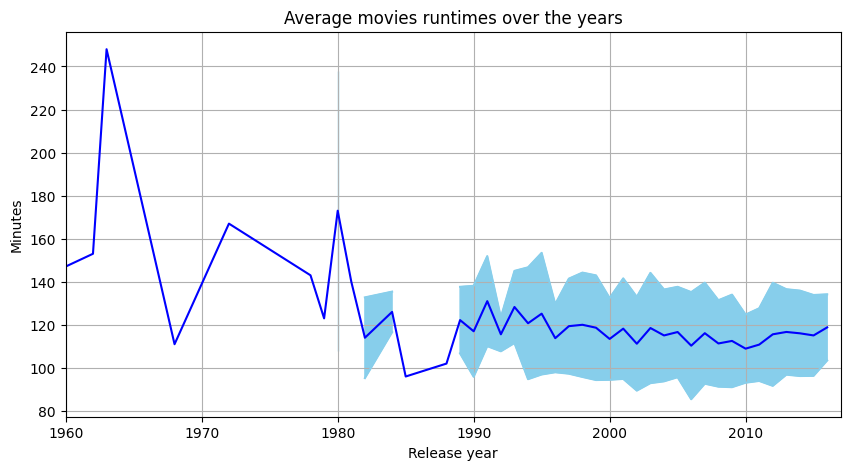

In [31]:
grouped_data = df_EDA['runtime'].groupby(df_EDA['year']).describe()
avg_runtime_by_year = grouped_data['mean']
avg_runtime_min = grouped_data['mean'] - grouped_data['std']
avg_runtime_max = grouped_data['mean'] + grouped_data['std']
fig, x = plt.subplots(figsize=(10,5))
x.plot(avg_runtime_by_year, color='blue')
x.plot(avg_runtime_min, color='skyblue')
x.plot(avg_runtime_max, color='skyblue')
x.fill_between(grouped_data.index, avg_runtime_min, avg_runtime_max, color="skyblue")
x.set_title('Average movies runtimes over the years')
x.set_xlabel('Release year')
x.set_ylabel('Minutes')
x.set_xlim(1960,2017)
plt.grid(True)
plt.show()

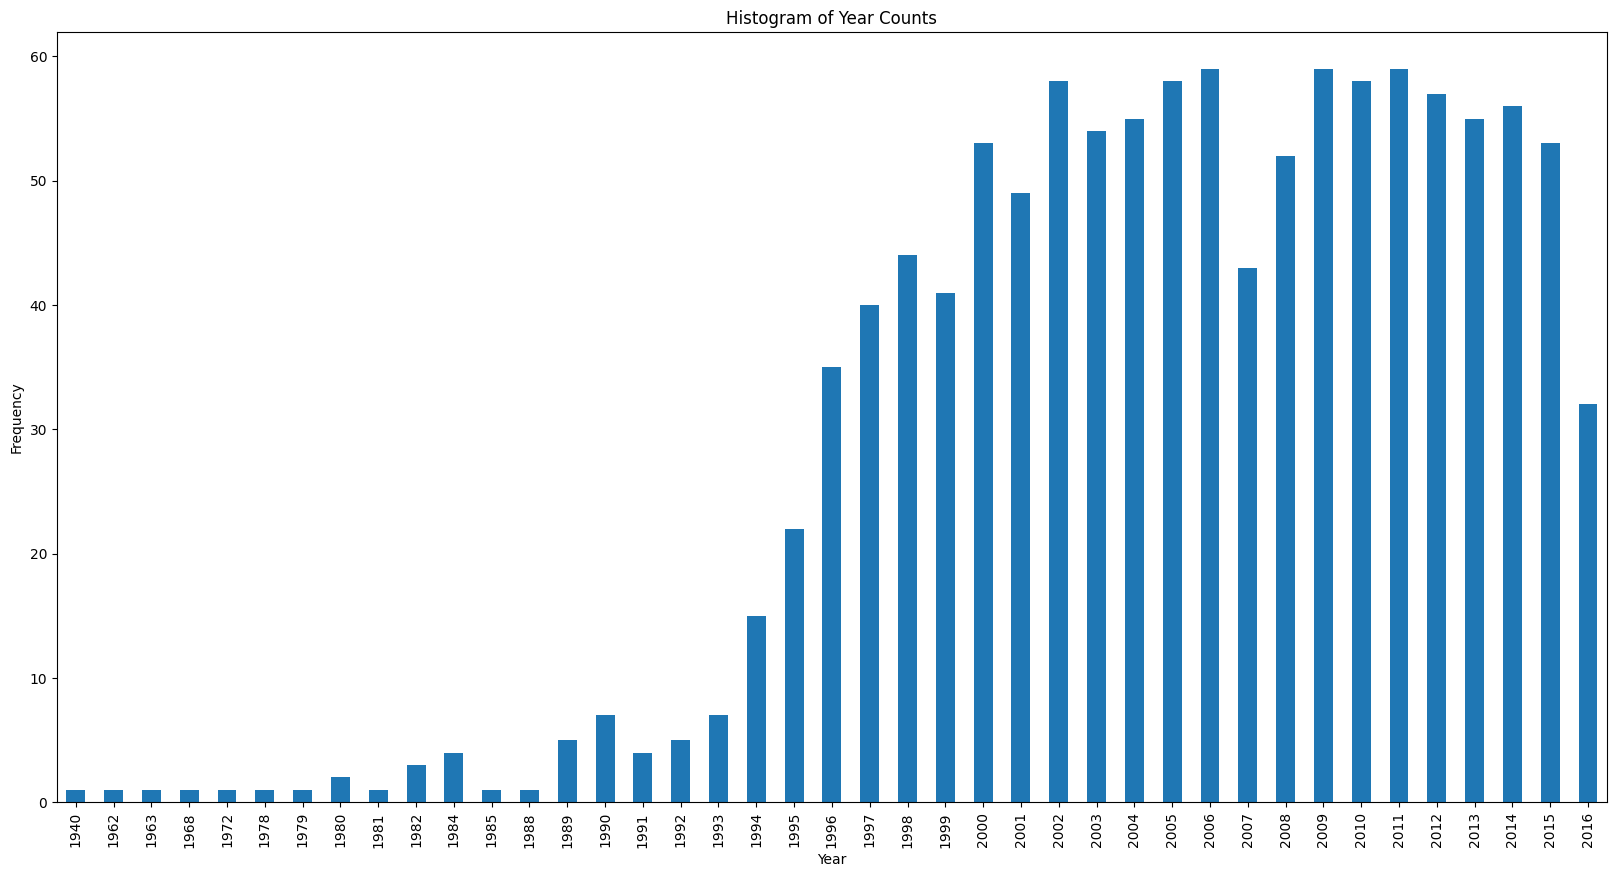

In [32]:
year_count = df_EDA.sort_values('year').groupby('year').size()
#print(year_count)
plt.figure(figsize=(20, 10))
year_count.plot(kind = 'bar')
#plt.hist(year_count.index, bins=len(year_count), weights=year_count.values, edgecolor='black')
plt.xticks(rotation= 90)
plt.title('Histogram of Year Counts')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

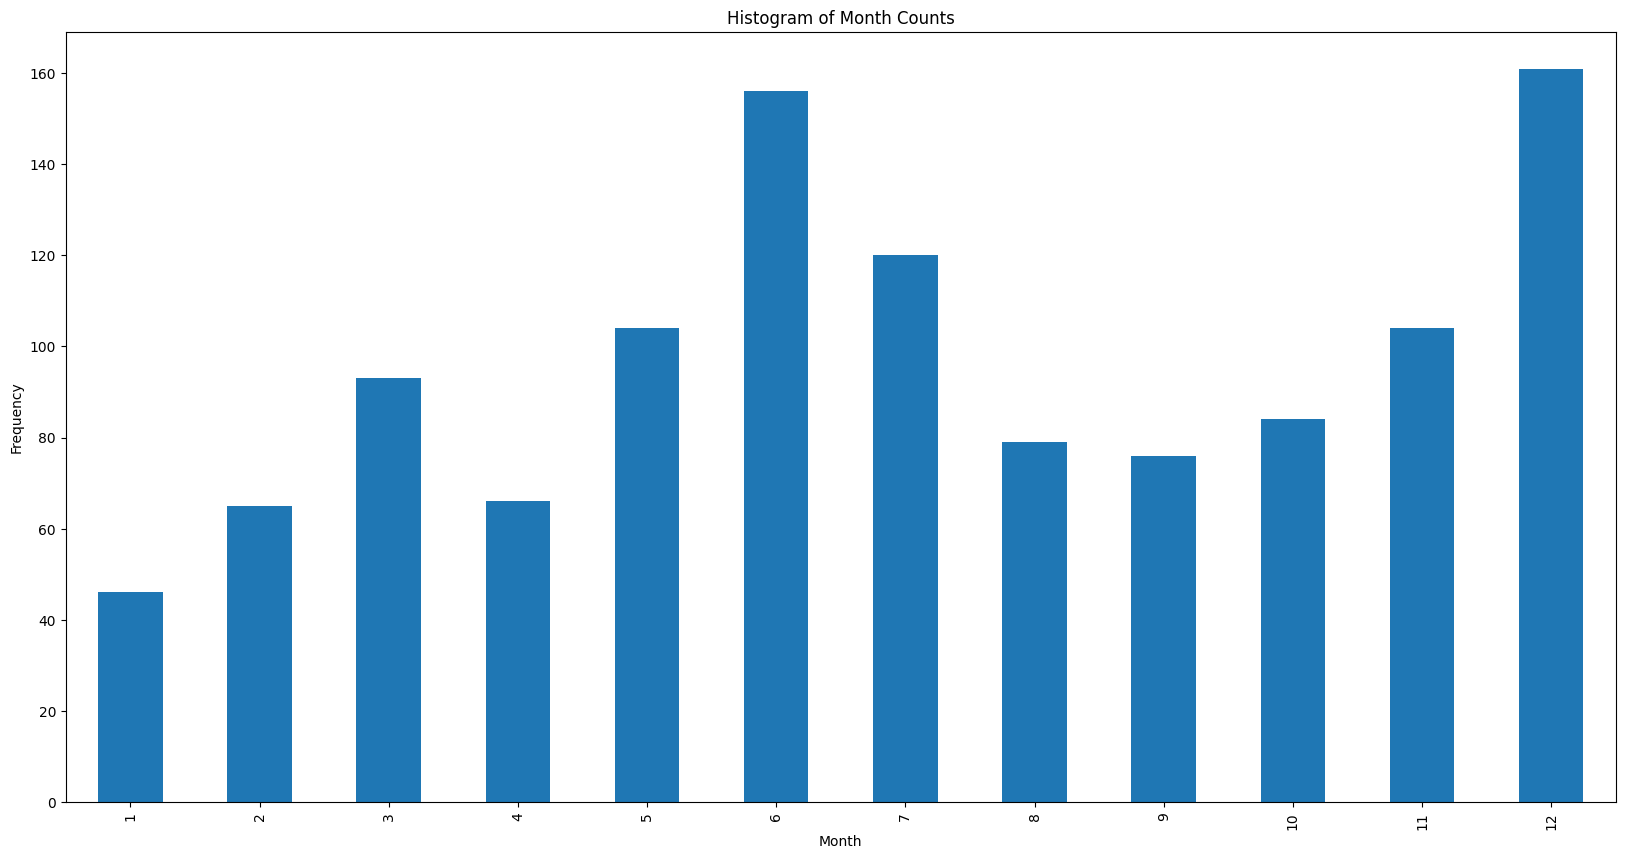

In [33]:
df_EDA['month'] = df_EDA['release_date'].dt.month
month_count = df_EDA.groupby('month').size()
plt.figure(figsize=(20, 10))
month_count.plot(kind='bar')
plt.title('Histogram of Month Counts')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

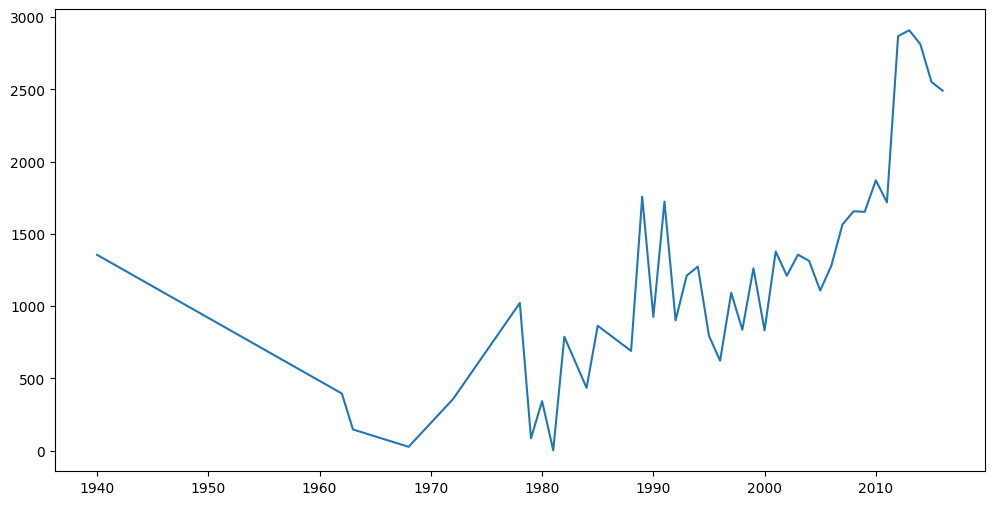

In [34]:
plt.figure(figsize=(12,6))
grouped_data = df_EDA.groupby('year')['vote_count'].mean()
plt.plot(grouped_data.index, grouped_data)
plt.show()

### Keywords

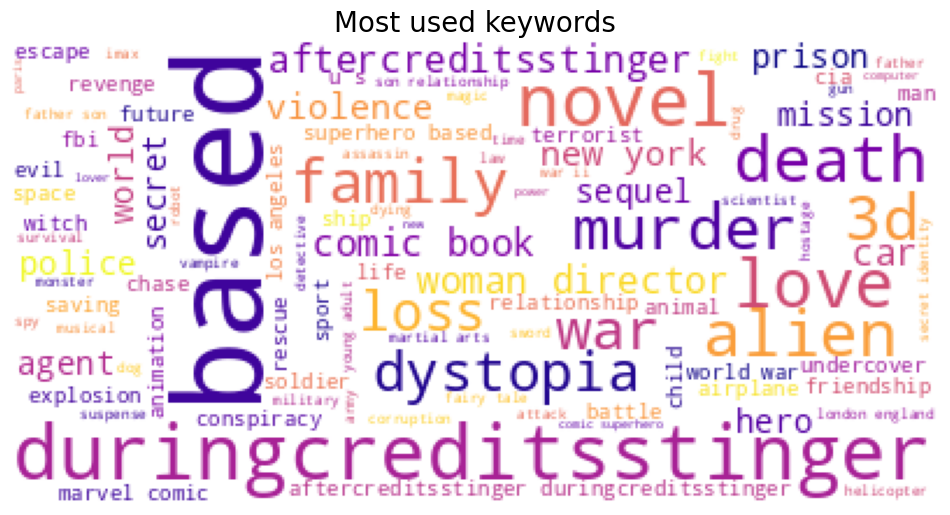

In [35]:
text = ','.join(' '.join([item['name'] for item in json.loads(keyword)]) for keyword in df_EDA['keywords'])
wc = WordCloud(max_words=100, background_color='white', colormap='plasma').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.title("Most used keywords", fontsize = 20)
plt.axis('off')  # Hide axis
plt.show()

In [44]:
# Initialize a dictionary to store actors and their cumulative popularity
actors_popularity = {}

# Iterate through each movie
for index, row in df_EDA.iterrows():
    cast = json.loads(row['cast'])
    popularity = row['popularity']

    # Accumulate popularity for each actor
    for actor in cast:
        actor_name = actor['name']
        actors_popularity[actor_name] = actors_popularity.get(actor_name, 0) + popularity

# Sort actors by cumulative popularity
sorted_actors = sorted(actors_popularity.items(), key=lambda x: x[1], reverse=True)

# Select the top 50 actors
top_50_actors = sorted_actors[:50]
top_50_name = []
# Print the top 20 actors
for rank, (actor, popularity) in enumerate(top_50_actors, 1):
    print(f"Rank {rank}: {actor} - Cumulative Popularity: {popularity}")
    top_50_name.append(actor)

Rank 1: Stan Lee - Cumulative Popularity: 3124.006588
Rank 2: Matt Damon - Cumulative Popularity: 1949.2487350000004
Rank 3: Samuel L. Jackson - Cumulative Popularity: 1896.0809090000007
Rank 4: Geoffrey Rush - Cumulative Popularity: 1886.2663770000001
Rank 5: Michael Caine - Cumulative Popularity: 1689.753517
Rank 6: Morgan Freeman - Cumulative Popularity: 1634.6052970000005
Rank 7: Ava Acres - Cumulative Popularity: 1577.409455
Rank 8: Steve Coogan - Cumulative Popularity: 1464.819581
Rank 9: Steve Carell - Cumulative Popularity: 1448.1174400000002
Rank 10: Johnny Depp - Cumulative Popularity: 1419.748489
Rank 11: Gary Oldman - Cumulative Popularity: 1387.6530780000003
Rank 12: Orlando Bloom - Cumulative Popularity: 1356.082984
Rank 13: John Ratzenberger - Cumulative Popularity: 1321.814981
Rank 14: Bruce Willis - Cumulative Popularity: 1320.1015109999998
Rank 15: Liam Neeson - Cumulative Popularity: 1295.704017
Rank 16: Hugo Weaving - Cumulative Popularity: 1280.705771
Rank 17: Mich

In [45]:
# Check if each actor in the DataFrame is among the top 50 actors
df_EDA['in_top_50'] = df_EDA['cast'].apply(lambda x: sum(actor['name'] in top_50_name for actor in json.loads(x)))
df_EDA['in_top_50']

,in_top_50
0,1
1,4
2,0
3,6
4,0
...,...
1149,0
1150,1
1151,0
1152,0


## Machine Learning and Modeling

#### Data preprocessing and Data Spliting

In [46]:
# Filtering the movies into the new df (df_ML)
df_ML = df_EDA.copy(deep = True)

# Calculate mean and standard deviation of the profit column
mean_profit = df_ML['profit'].mean()
std_profit = df_ML['profit'].std()

# Define the success criterion function
def is_successful(profit):
    if  profit >= mean_profit + std_profit:
      return 1
    return 0

# Apply the success criterion as a filter and create a new column indicating success
df_ML['is_successful'] = df_ML['profit'].apply(is_successful)

In [47]:
# Calculate the success rate
success_rate = sum(df_ML['is_successful'] == 1) / len(df_ML) * 100

# Print the success rate with two decimal places
print(f"Success rate is {success_rate:.2f}%")

Success rate is 12.31%


In [48]:
columns_for_X = ['budget', 'runtime', 'year', 'in_top_50']
X = df_ML[columns_for_X]
y = df_ML['is_successful']

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression(random_state = 0)
classifier_logistic.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [52]:
y_pred = classifier_logistic.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[201   4]
 [ 16  10]]


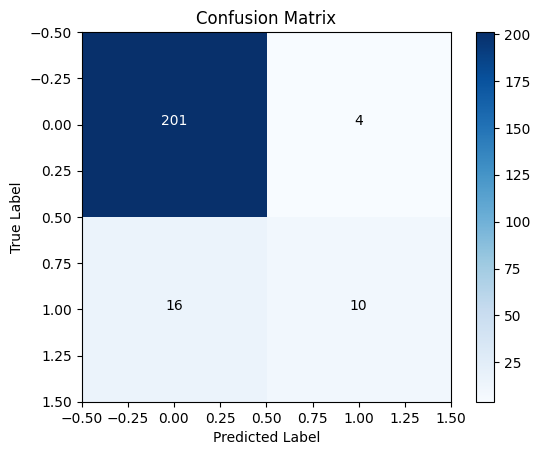

Accuracy: 0.9134
Precision: 0.7143
Recall: 0.3846
F1-Score: 0.5000


In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [55]:
y_pred = classifier_dt.predict(X_test)


[[191  14]
 [ 19   7]]


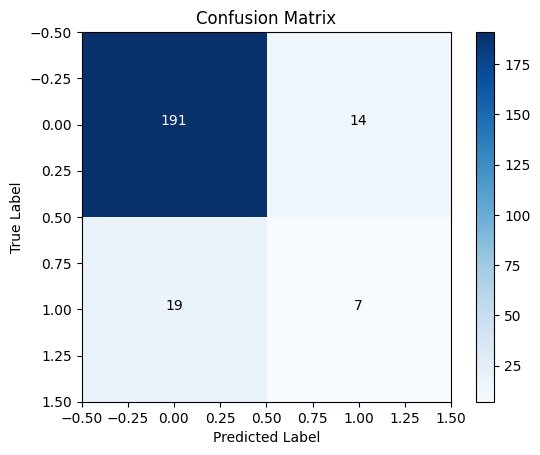

Accuracy: 0.8571
Precision: 0.3333
Recall: 0.2692
F1-Score: 0.2979


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [58]:
y_pred = classifier_rf.predict(X_test)

[[198   7]
 [ 18   8]]


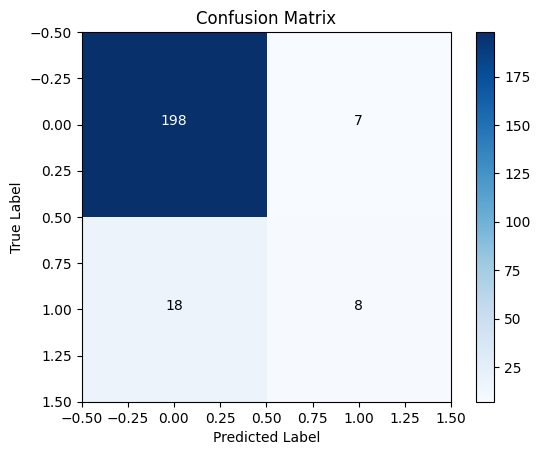

Accuracy: 0.8918
Precision: 0.5333
Recall: 0.3077
F1-Score: 0.3902


In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### XGBoost

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [61]:
y_pred = classifier_xgb.predict(X_test)

[[297  11]
 [ 27  12]]


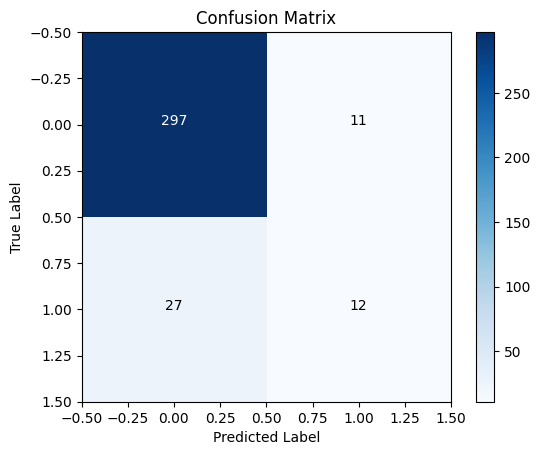

Accuracy: 0.8905
Precision: 0.5217
Recall: 0.3077
F1-Score: 0.3871


In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


In [63]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_xgb, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 86.37 %
Standard Deviation: 2.69 %


#### ROC

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


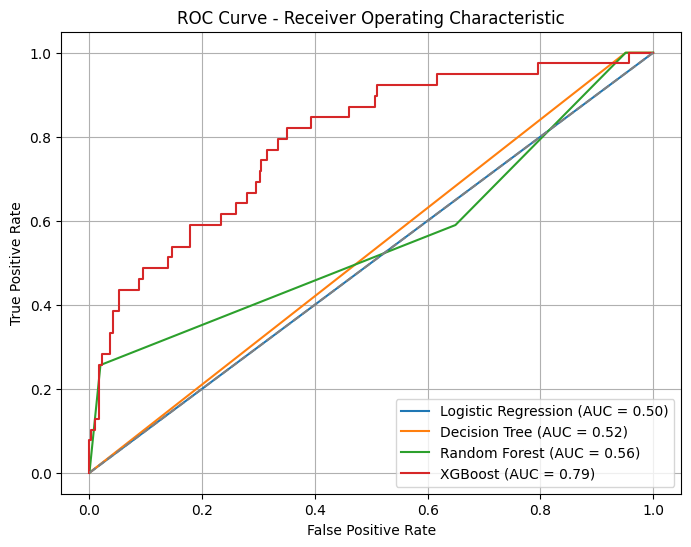

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define the models and their names
models = [classifier_logistic, classifier_dt, classifier_rf, classifier_xgb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

# Initialize a figure
plt.figure(figsize=(8, 6))

# Plot ROC curve and calculate AUC for each model
for model, model_name in zip(models, model_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Plot ROC curve for random classifier (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show plot
plt.grid(True)
plt.show()


### Picking Features with PCA

#### Data preprocessing and Data Spliting

In [65]:
columns_for_X = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'in_top_50']
X = df_ML[columns_for_X]
y = df_ML['is_successful']

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [67]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression(random_state = 0)
classifier_logistic.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [70]:
y_pred = classifier_logistic.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[205   0]
 [  1  25]]


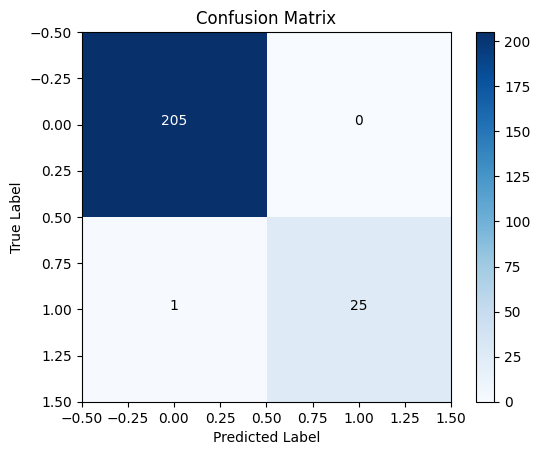

Accuracy: 0.9957
Precision: 1.0000
Recall: 0.9615
F1-Score: 0.9804


In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [73]:
y_pred = classifier_dt.predict(X_test)


[[202   3]
 [  0  26]]


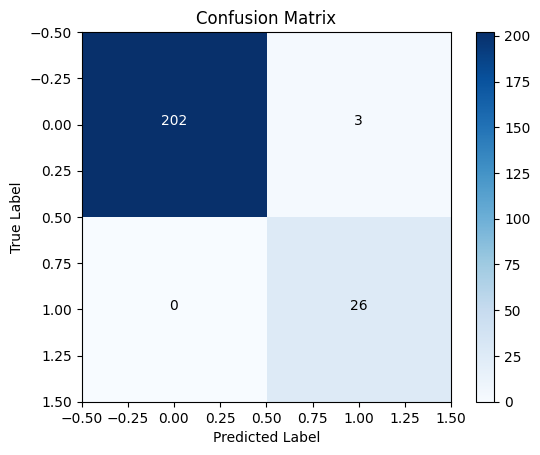

Accuracy: 0.9870
Precision: 0.8966
Recall: 1.0000
F1-Score: 0.9455


In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [76]:
y_pred = classifier_rf.predict(X_test)

[[203   2]
 [  4  22]]


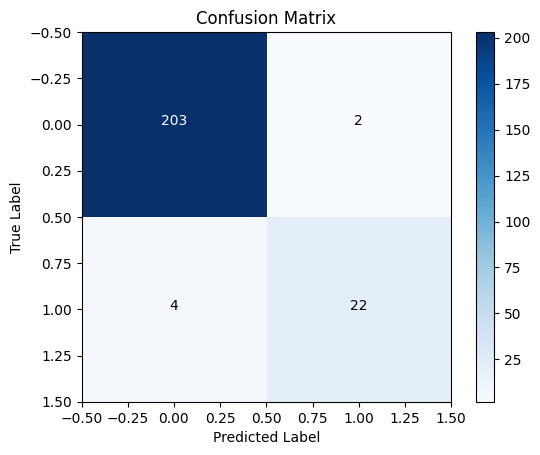

Accuracy: 0.9740
Precision: 0.9167
Recall: 0.8462
F1-Score: 0.8800


In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### XGBoost

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [79]:
y_pred = classifier_xgb.predict(X_test)

[[307   1]
 [  3  36]]


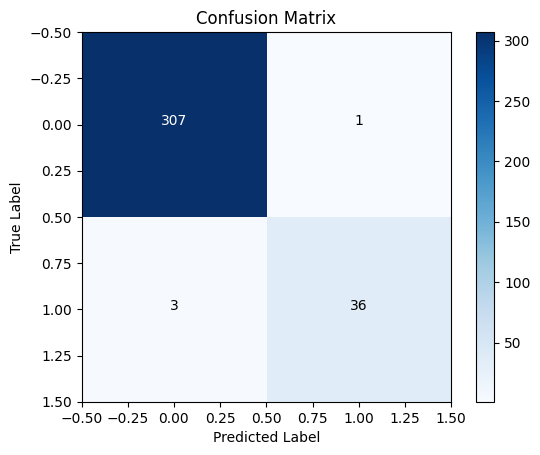

Accuracy: 0.9885
Precision: 0.9730
Recall: 0.9231
F1-Score: 0.9474


In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


In [81]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_xgb, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 99.25 %
Standard Deviation: 1.14 %


#### ROC

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


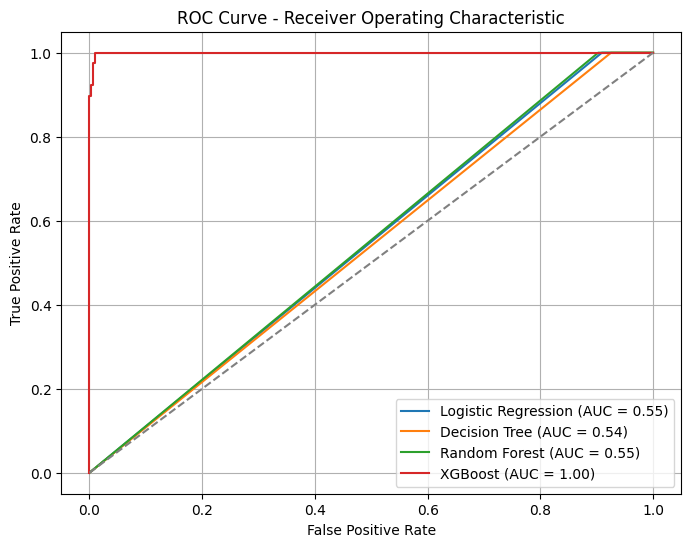

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define the models and their names
models = [classifier_logistic, classifier_dt, classifier_rf, classifier_xgb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

# Initialize a figure
plt.figure(figsize=(8, 6))

# Plot ROC curve and calculate AUC for each model
for model, model_name in zip(models, model_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Plot ROC curve for random classifier (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show plot
plt.grid(True)
plt.show()


## Recommender Systems

### Plot description based Recommender
Compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score.

In [83]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1154, 9627)

In [84]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [85]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [86]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df.iloc[movie_indices]['title']

In [89]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    # Convert title to lowercase for case-insensitive matching
    title = title.lower()
    # Check if the title (or a case-insensitive version) exists in the index
    if title in indices or title.title() in indices or title.upper() in indices:
        idx = indices[title] if title in indices else (indices[title.title()] if title.title() in indices else indices[title.upper()])
    else:
        print(f"Movie '{title}' not found in the dataset.")
        return None  # Or handle the case differently

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df.iloc[movie_indices]['title']

In [92]:
get_recommendations('Whiplash')

Movie 'whiplash' not found in the dataset.


In [93]:
get_recommendations('Superman')

,title
870,Superman II
10,Superman Returns
914,Central Intelligence
45,World War Z
770,Event Horizon
